In [1]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162675 sha256=3d5ea7bb06327d0b4fe60b4201a88f703b3b694817cbdca391d544c59a111472
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer

from sklearn import preprocessing
import scipy
import random
import seaborn as sns

from surprise import AlgoBase, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split, GridSearchCV
import pandas as pd
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

from sklearn.model_selection import train_test_split as sklearn_train_test_split

# models
from surprise import KNNWithZScore, SVD


In [3]:
movies = pd.read_csv("movies.csv")
movies.drop_duplicates(subset ="title",keep='first',inplace=True,ignore_index=True)


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.shape

(9737, 3)

In [6]:
print(movies.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


In [7]:
duplicates = movies[movies.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [movieId, title, genres]
Index: []


In [8]:
movies.nunique()

movieId    9737
title      9737
genres      951
dtype: int64

In [9]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


<Axes: >

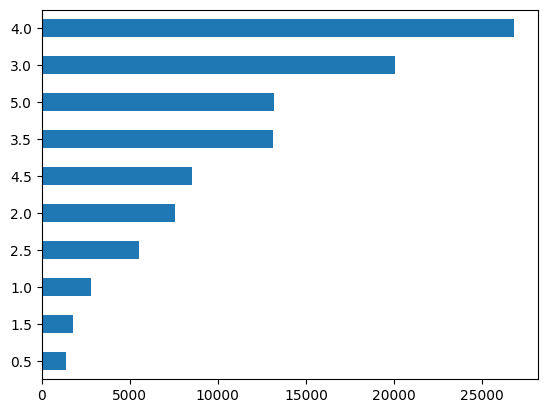

In [11]:
ratings.rating.value_counts().sort_values().plot(kind='barh')

In [12]:
combined_dataset = pd.merge(movies, ratings, how='left', on='movieId')
highest_rating = combined_dataset.groupby('title')[['rating']].count().nlargest(20, 'rating')
print(highest_rating)

                                                    rating
title                                                     
Forrest Gump (1994)                                    329
Shawshank Redemption, The (1994)                       317
Pulp Fiction (1994)                                    307
Silence of the Lambs, The (1991)                       279
Matrix, The (1999)                                     278
Star Wars: Episode IV - A New Hope (1977)              251
Jurassic Park (1993)                                   238
Braveheart (1995)                                      237
Terminator 2: Judgment Day (1991)                      224
Schindler's List (1993)                                220
Fight Club (1999)                                      218
Toy Story (1995)                                       215
Star Wars: Episode V - The Empire Strikes Back ...     211
American Beauty (1999)                                 204
Usual Suspects, The (1995)                             2

In [13]:
#check for missing values
print(ratings.isnull().sum())
print(ratings.shape)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
(100836, 4)


In [14]:
ratings.dropna(inplace=True)
print(ratings.shape)
ratings.isnull().sum()

(100836, 4)


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [15]:
#ckeck for duplicates
duplicates_ratings = ratings[ratings.duplicated()]
print(duplicates_ratings)

Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


In [16]:
# Show unique values in ratings dataframe
ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

In [17]:
tags = pd.read_csv('tags.csv')
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [18]:
#check for missing values
print(tags.isnull().sum())
print(tags.shape)

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
(3683, 4)


In [19]:
duplicates_tags = tags[tags.duplicated()]
print(duplicates_tags)

Empty DataFrame
Columns: [userId, movieId, tag, timestamp]
Index: []


In [20]:
tags.nunique()

userId         58
movieId      1572
tag          1589
timestamp    3411
dtype: int64

In [21]:
#Merge movies and ratings
matrix = pd.merge(ratings, movies, on='movieId', how='left')
matrix.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [22]:
duplicates_matrix = matrix[matrix.duplicated()]
print(duplicates_matrix)
matrix.isnull().sum()
matrix.dropna(inplace=True)

Empty DataFrame
Columns: [userId, movieId, rating, timestamp, title, genres]
Index: []


In [23]:
matrix.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [24]:
matrix = matrix.drop(['timestamp'], axis=1)
matrix.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [25]:
matrix['year'] = matrix['title'].str.extract('.*\((.*)\).*',expand = False)
matrix.head()


,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [26]:
#Check sparsity of matrix
numratings = len(matrix['rating'])
numusers = len(matrix['userId'].unique())
numitems = len(matrix['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9829925833967267

In [27]:
filtered_data = matrix.copy()

# Filter movies with more than 50 ratings
movie_counts = filtered_data['movieId'].value_counts()
popular_movies = movie_counts[movie_counts > 50].index
filtered_data = filtered_data[filtered_data['movieId'].isin(popular_movies)]


# Check the new sparsity
num_ratings_filtered = len(filtered_data)
num_users_filtered =  len(filtered_data['userId'].unique())
num_items_filtered = len(filtered_data['movieId'].unique())
sparsity_filtered = 1 - (num_ratings_filtered / (num_users_filtered * num_items_filtered))

# Print the new sparsity
print(sparsity_filtered)

0.8461107578647773


In [28]:
#Check for NA values
filtered_data.isna().sum()


userId     0
movieId    0
rating     0
title      0
genres     0
year       0
dtype: int64

In [29]:
#See which movie Ids have the highest number of views
filtered_data['movieId'].value_counts()


356     329
318     317
296     307
593     279
2571    278
       ... 
1215     51
2100     51
4776     51
4848     51
4239     51
Name: movieId, Length: 436, dtype: int64

In [30]:
print(filtered_data.shape)
print(matrix.shape)

(40660, 6)
(100830, 6)


In [31]:
#See which users have provided the most ratings
filtered_data['userId'].value_counts()

414    416
68     383
599    378
480    341
274    340
      ... 
207      2
158      2
138      2
545      2
578      2
Name: userId, Length: 606, dtype: int64

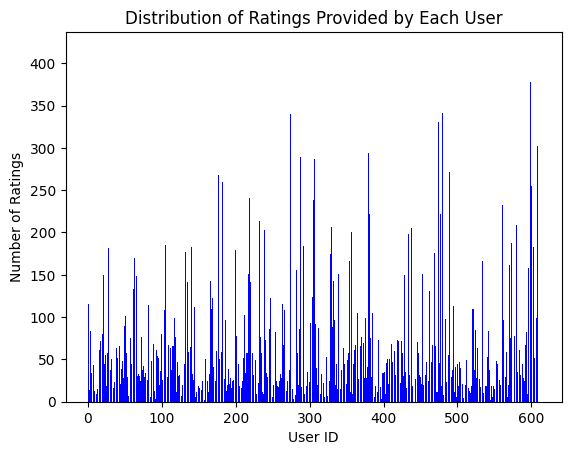

<BarContainer object of 10 artists>

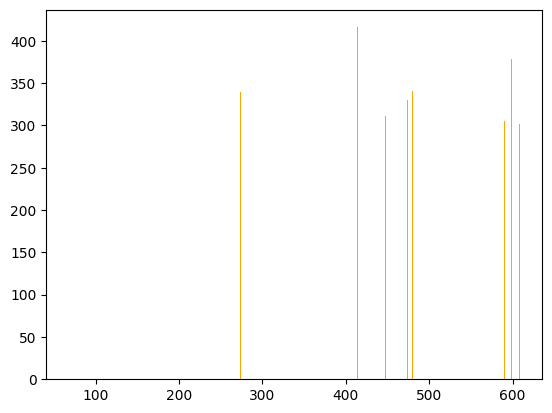

In [32]:
user_ratings_counts=filtered_data['userId'].value_counts()
plt.bar(user_ratings_counts.index,user_ratings_counts.values, color='blue')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Ratings Provided by Each User')
plt.show()
sorted_user_ratings = user_ratings_counts.sort_values(ascending=False)
top_users = sorted_user_ratings.head(10)
plt.bar(top_users.index, top_users.values, color='orange')

In [33]:
#View the distribution of ratings
filtered_data['rating'].value_counts()

4.0    11805
5.0     7556
3.0     7207
3.5     4839
4.5     4152
2.0     2044
2.5     1539
1.0      766
1.5      384
0.5      368
Name: rating, dtype: int64

In [34]:
#View the distribution of years
filtered_data['year'].value_counts()

1995    3821
1994    3543
1999    2411
1993    2394
2000    2003
        ... 
1959      57
1957      57
1955      55
2013      54
2016      54
Name: year, Length: 63, dtype: int64

In [35]:
#Investigate the number of unique years
filtered_data['year'].nunique()

63

In [36]:
filtered_data.groupby('title').size().sort_values(ascending=False)

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Bad Boys (1995)                      51
Army of Darkness (1993)              51
The Devil's Advocate (1997)          51
Mulholland Drive (2001)              51
Training Day (2001)                  51
Length: 436, dtype: int64

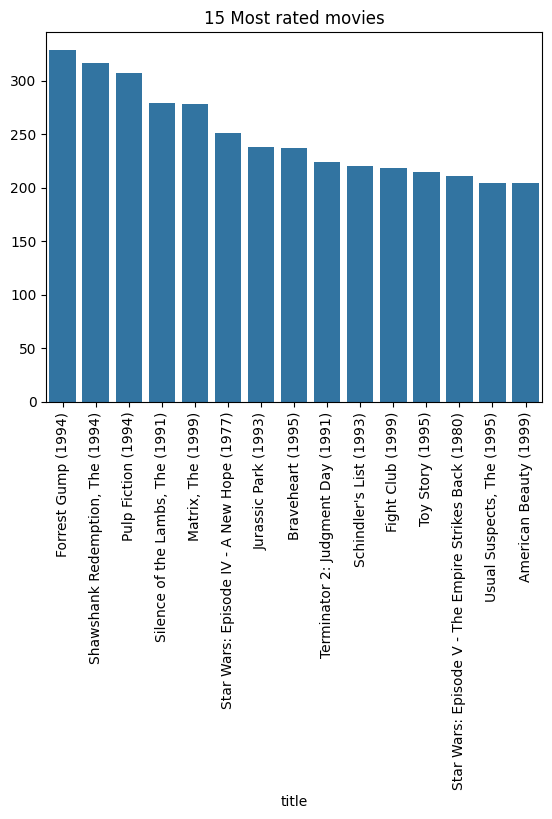

In [37]:
# Look at how many ratings each movie has
movies_ratings=filtered_data.groupby('title').size().sort_values(ascending=False).head(15)
sns.barplot(x=movies_ratings.index, y=movies_ratings.values)
plt.title('15 Most rated movies')
plt.xticks(rotation=90);

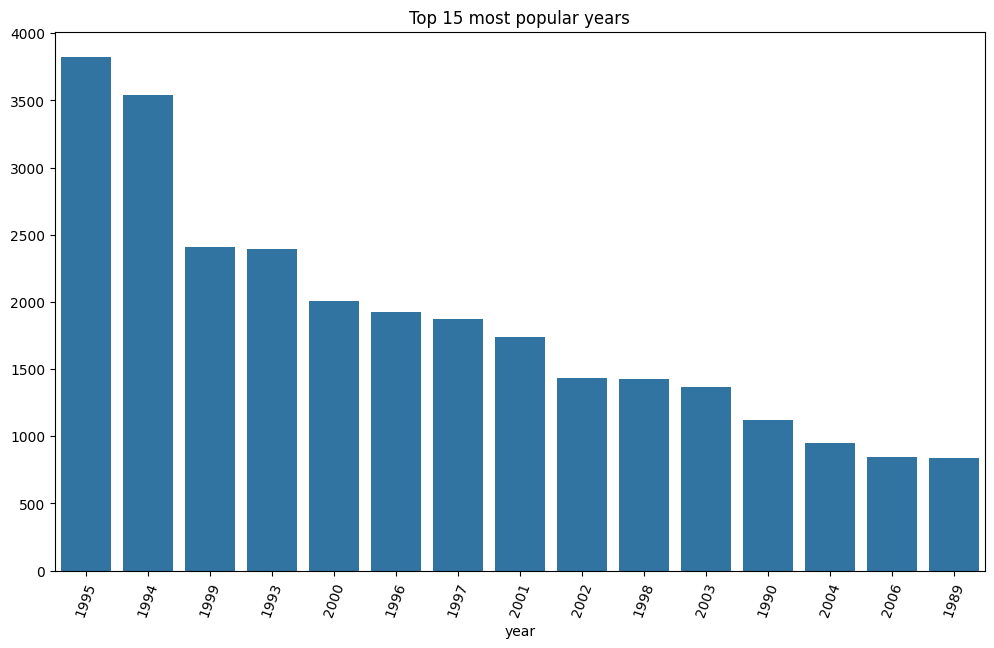

In [38]:
plt.figure(figsize=(12,7))
popular_year = filtered_data.groupby('year').size().sort_values(ascending=False).head(15)
sns.barplot(x=popular_year.index, y=popular_year.values)
plt.title('Top 15 most popular years')
plt.xticks(rotation=70);

In [39]:
filtered_data.groupby('title').mean()['rating'].sort_values(ascending=False)

<ipython-input-39-58cda51df0c9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered_data.groupby('title').mean()['rating'].sort_values(ascending=False)


title
Shawshank Redemption, The (1994)                                               4.429022
Godfather, The (1972)                                                          4.289062
Fight Club (1999)                                                              4.272936
Cool Hand Luke (1967)                                                          4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)    4.268041
                                                                                 ...   
Johnny Mnemonic (1995)                                                         2.679245
Judge Dredd (1995)                                                             2.669355
City Slickers II: The Legend of Curly's Gold (1994)                            2.645455
Coneheads (1993)                                                               2.420635
Wild Wild West (1999)                                                          2.207547
Name: rating, Length: 436,

<ipython-input-40-40c9047046c6>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  popular_movies = filtered_data.groupby('title').mean()['rating'].sort_values(ascending=False).head(15)


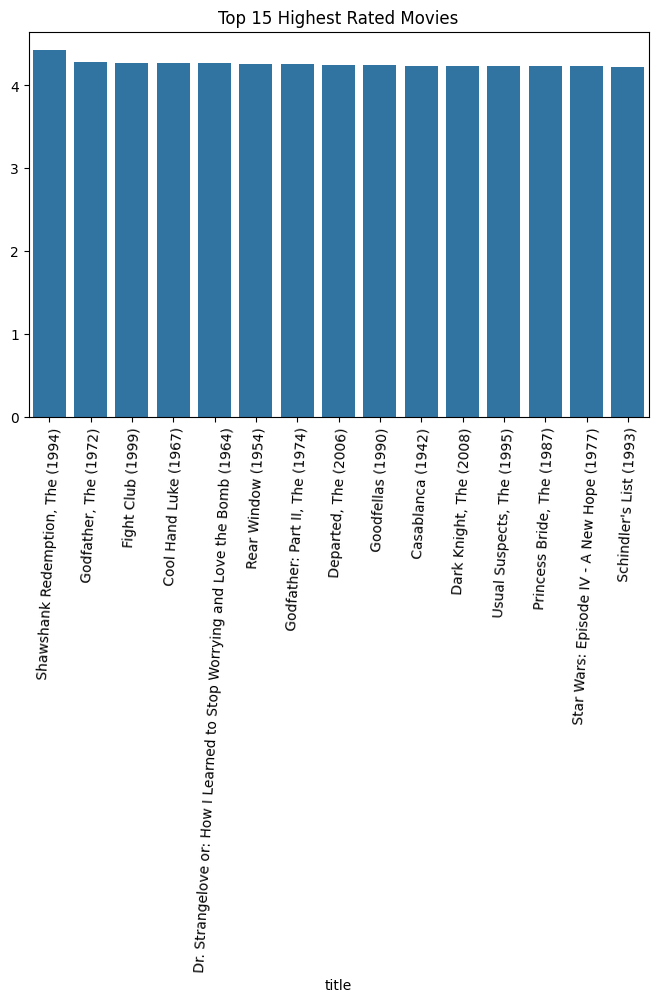

In [40]:
plt.figure(figsize=(8,5))
popular_movies = filtered_data.groupby('title').mean()['rating'].sort_values(ascending=False).head(15)
sns.barplot(x=popular_movies.index, y=popular_movies.values)
plt.title('Top 15 Highest Rated Movies')
plt.xticks(rotation=87);

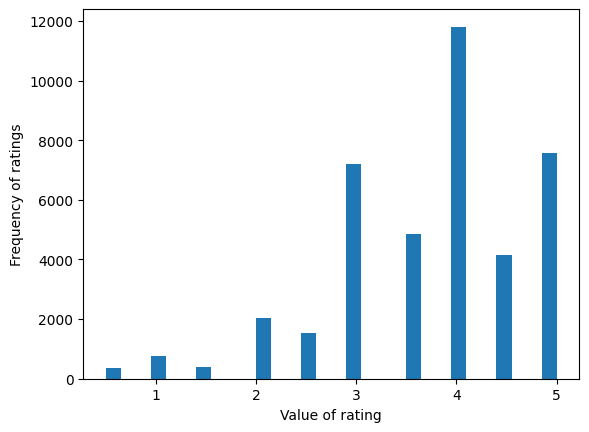

In [41]:
#Plot a histogram of the frequency of certain rating values
plt.hist(filtered_data['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

In [42]:
genre_labels = set()
for i in filtered_data['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(i))
genre_labels

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

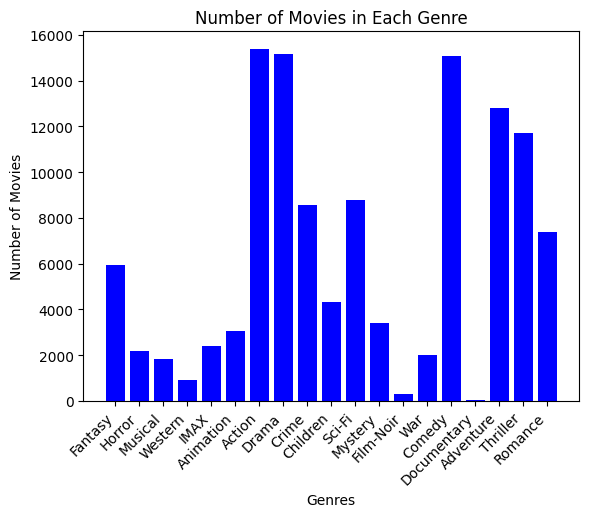

In [43]:
#function to see how many movies of each genre exist in our dataset
def counts_genre(df, col, labels):
    count = dict()
    for i in labels:
        count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value):
            continue
        for i in value:
            if pd.notnull(i):
                count[i] += 1
    return count

genre_counts = counts_genre(filtered_data, 'genres', genre_labels)

# Plotting the histogram
plt.bar(genre_counts.keys(), genre_counts.values(), color='blue')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Genre')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

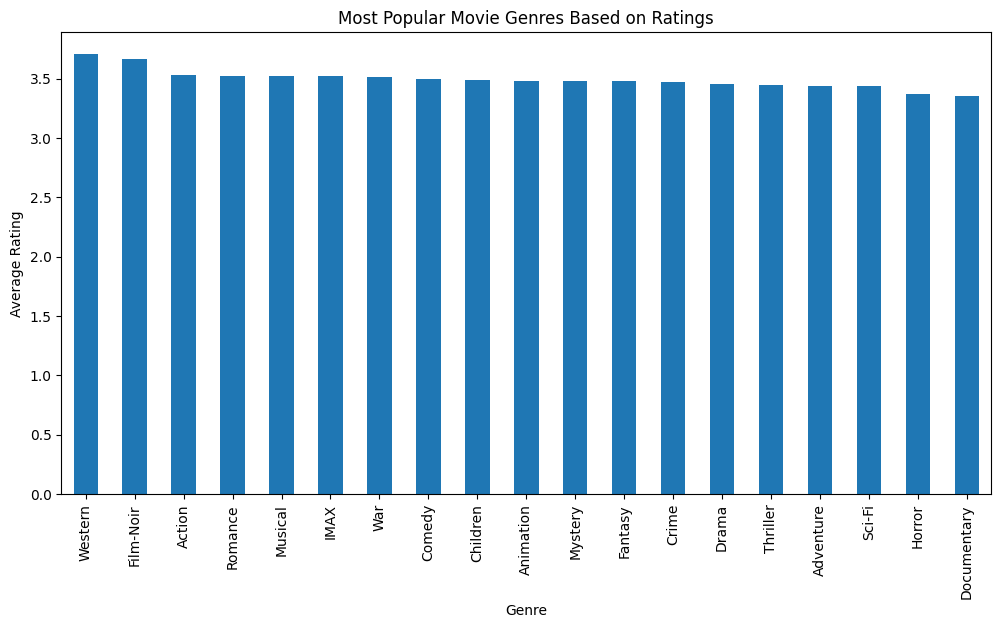

In [44]:
#Merge ratings and movies DataFrames
movie_ratings = pd.merge(ratings, movies, on='movieId')

#Split genres and create a new DataFrame
genres_df = movie_ratings['genres'].str.split('|', expand=True)
genres_df = genres_df.stack().reset_index(level=1, drop=True).reset_index()
genres_df.columns = ['movieId', 'genre']

#Merge ratings, movies, and genres DataFrames
movie_ratings_genres = pd.merge(movie_ratings, genres_df, on='movieId')

#Calculate average rating for each genre
genre_avg_ratings = movie_ratings_genres.groupby('genre')['rating'].mean()

#Plot the most popular genres based on average ratings
plt.figure(figsize=(12, 6))
genre_avg_ratings.sort_values(ascending=False).plot(kind='bar')
plt.title('Most Popular Movie Genres Based on Ratings')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()